# Code for analyzing volume output
- Uses volumetric data CSVs (../results/) generated by "collect_volumes.sh" script part of [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
- Uses participants data (../metadata/) for inclusion/exclusion criteria and demographic info
- Uses brain-masks from fmriprep preprocessing to calculate brain volume (not part of this repo)
## Cohorts
- Normal Controls, Essential Tremor, Parkinsons
## Tasks
- Compare total cerebellar volumes (left and right)
- Compare lobule volumes (13 per hemisphere)
## Covariates
- Age, Sex, TBV


In [1]:
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nibabel as nib

sys.path.append('../')
from lib.stats_utils import *

### Paths

In [2]:
project_dir = '../../../'
data_dir = project_dir + 'data/preproc_T1s/'
metadata_dir = '../metadata/'
results_dir = '../results/MAGeT/'

### Participant demographics

In [3]:
participant_df = pd.read_csv('{}participants.csv'.format(metadata_dir))

# exclusions
exclude_subjects = list(participant_df[participant_df['Include in analysis']==0]['Participant_id'])
exclude_subjects = exclude_subjects + ['sub-0123'] # Age unknow ['?']

participant_df = participant_df[~participant_df['Participant_id'].isin(exclude_subjects)]
include_subjects = participant_df['Participant_id'].values
print('Total number of participants included: {} (excluded: {})'.format(len(include_subjects),len(exclude_subjects)))

# reformat columns
participant_df['Age'] = participant_df['Age'].astype(np.int)
age_df = participant_df.groupby(['group','Sex'])[['Age']].mean()
sex_df = participant_df.groupby(['group','Sex']).count()['Participant_id']

print(pd.merge(age_df,sex_df,on=['group','Sex']))

## Check preproc subject count

failed_subjects = set(include_subjects) - set(participant_df[participant_df['MAGeT processing']==1]['Participant_id'])
print('\nMAGet failures: {}'.format(failed_subjects))

participant_df[participant_df['Participant_id'].isin(failed_subjects)]

Total number of participants included: 113 (excluded: 22)
                 Age  Participant_id
group Sex                           
ET    F    72.600000              10
      M    73.678571              28
NC    F    58.636364              11
      M    55.095238              21
PD    F    62.375000              16
      M    62.259259              27

MAGet failures: set()


,Participant_id,Age,Sex,group,Include in analysis,conversion Problem,opteration,T1w,T2w,dwi,...,bold fmap,swi,fmriprep (ses-1) anat only,freesurfer-6.0.1,fmriprep (ses-1) anat + bold prprocessing,T1-QC,T1-template,SUIT () cerebellum segmentation,MAGeT processing,MAGet Comments


In [4]:
demograph_columns = ['Participant_id',	'Age',	'Sex',	'group']

analysis_df = participant_df[~participant_df['Participant_id'].isin(failed_subjects)][demograph_columns]
print('Total number of participants in the analysis: {} (excluded failed preproc: {})'.format(len(analysis_df),len(failed_subjects)))
analysis_df.head()

Total number of participants in the analysis: 113 (excluded failed preproc: 0)


,Participant_id,Age,Sex,group
0,sub-0002,70,M,PD
1,sub-0004,76,F,PD
2,sub-0005,45,M,PD
3,sub-0006,63,F,PD
4,sub-0008,59,M,PD


### Grab total brain volumes from the masks

In [5]:
groups = ['NC','ET','PD']

mask_df = pd.DataFrame(columns=['Participant_id','group','brain_volume'])

i = 0
for grp in groups:
    mask_dir = data_dir + '{}/masks/'.format(grp)

    mask_paths = os.listdir(mask_dir)

    for m, mask_path in enumerate(mask_paths):
        sub_name = mask_path.rsplit('-',1)[0]
        mask_path = mask_dir + sub_name + '-brain_mask.nii.gz' 
        
        # load anothor image to mask
        mask = nib.load(mask_path)
        mask_data = mask.get_data()
        mask_df.loc[i] = [sub_name.split('_',1)[0], grp, np.sum(mask_data.ravel())]
        i=i+1
        
mask_df.head()

,Participant_id,group,brain_volume
0,sub-0062,NC,1571150
1,sub-0104,NC,1428372
2,sub-0058,NC,1228322
3,sub-0078,NC,1354347
4,sub-0080,NC,1407550


### Grab cerebellum volumes from segmentations

In [6]:

cols_L = ['L_I_II', 'L_III', 'L_IV', 'L_V', 'L_VI', 'L_Crus_I','L_Crus_II', 'L_VIIB', 'L_VIIIA', 'L_VIIIB', 'L_IX', 'L_X', 'L_CM']
cols_R = ['R_I_II', 'R_III', 'R_IV', 'R_V', 'R_VI', 'R_Crus_I', 'R_Crus_II','R_VIIB', 'R_VIIIA', 'R_VIIIB', 'R_IX', 'R_X', 'R_CM']

vol_df_concat = pd.DataFrame()
for grp in groups:
    vol_df = pd.read_csv('{}{}_volumes.csv'.format(results_dir,grp))
    vol_df['group'] = grp
    vol_df['Participant_id'] = vol_df['Subject'].str.split('_',expand=True)[0].str.split('/',expand=True)[1]
    vol_df['L_CB'] = vol_df[cols_L].sum(axis=1)
    vol_df['R_CB'] = vol_df[cols_R].sum(axis=1)
    vol_df_concat = vol_df_concat.append(vol_df)

vol_df_concat = pd.merge(vol_df_concat,mask_df,on=['Participant_id','group'],how='left')

# filter included subjects from participants demographics
vol_df_concat = vol_df_concat[vol_df_concat['Participant_id'].isin(include_subjects)]

# sort and count group sizes
vol_df_concat = vol_df_concat.sort_values(['group','Participant_id'])
group_sizes = vol_df_concat.value_counts(['group'])
print('Number of Participant_ids:\n{}'.format(group_sizes))

h_lines = np.cumsum(group_sizes.sort_index().values)[:-1]
v_lines = len(cols_L)

print('hlines: {}, vlines: {}'.format(h_lines,v_lines))

vol_df_concat.head()

Number of Participant_ids:
group
PD       43
ET       38
NC       32
dtype: int64
hlines: [38 70], vlines: 13


,Subject,L_I_II,L_III,L_IV,L_V,L_VI,L_Crus_I,L_Crus_II,L_VIIB,L_VIIIA,...,R_VIIIA,R_VIIIB,R_IX,R_X,R_CM,group,Participant_id,L_CB,R_CB,brain_volume
54,./sub-0016_ses-1_run-1_desc-masked_preproc_T1w...,75.0,979.0,2700.0,4822.0,8896.0,11257.0,9249.0,3517.0,6107.0,...,4448.0,3894.0,4662.0,599.0,7896.0,ET,sub-0016,64478.0,67298.0,1475141
47,./sub-0061_ses-1_run-1_desc-masked_preproc_T1w...,54.0,831.0,2519.0,3625.0,7201.0,10349.0,7570.0,3509.0,5316.0,...,3928.0,3239.0,2699.0,513.0,7526.0,ET,sub-0061,54314.0,57865.0,1400053
43,./sub-0081_ses-1_run-1_desc-masked_preproc_T1w...,125.0,895.0,2316.0,3468.0,6315.0,11410.0,6663.0,2828.0,5304.0,...,3606.0,3250.0,2911.0,632.0,6759.0,ET,sub-0081,53619.0,57589.0,1319141
40,./sub-0119_ses-1_run-1_desc-masked_preproc_T1w...,81.0,761.0,2063.0,3946.0,7193.0,11504.0,5921.0,2631.0,5290.0,...,3689.0,3378.0,2805.0,539.0,7418.0,ET,sub-0119,53280.0,56064.0,1340808
36,./sub-0122_ses-1_run-1_desc-masked_preproc_T1w...,42.0,677.0,2304.0,3402.0,6466.0,10819.0,5190.0,2729.0,4314.0,...,3135.0,2614.0,3074.0,541.0,6931.0,ET,sub-0122,49167.0,49558.0,1296432


## Plots

### Total volumes: Individuals
- Cerebellum (L and R) compared with TBV

Normalizing cerebellum volume with TBV


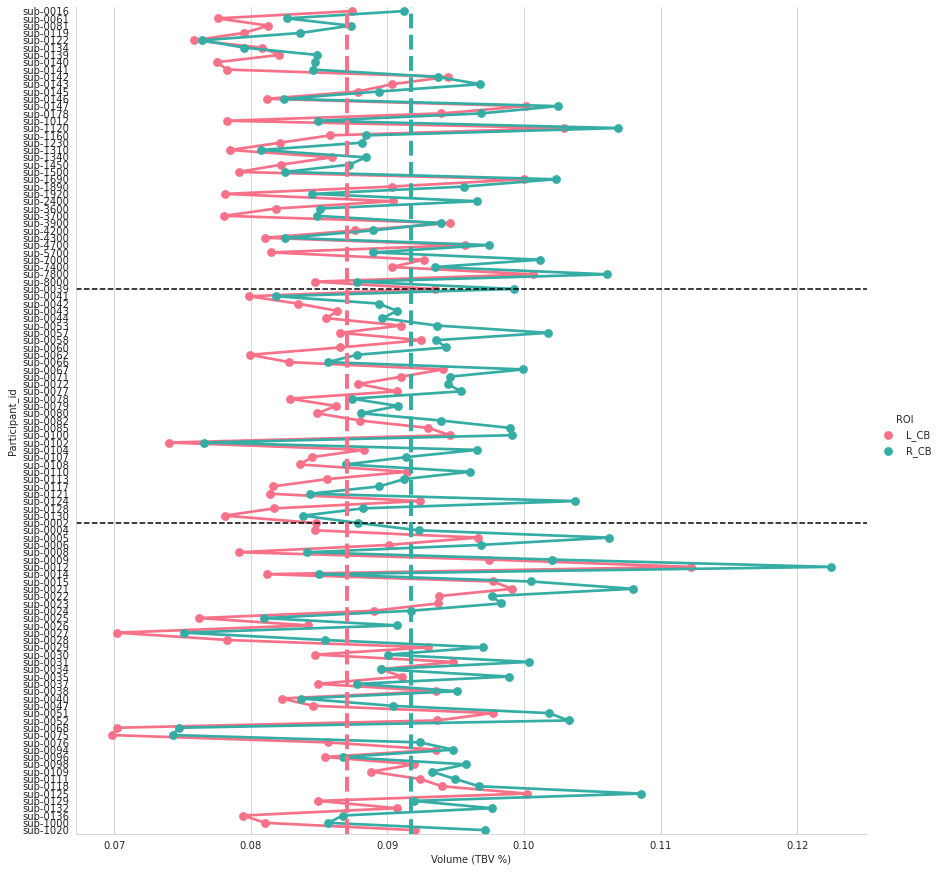

In [7]:
plot_df = vol_df_concat.copy()
plot_df[['Participant_id','group','L_CB','L_CB','brain_volume']]

normalize = True

if normalize:
    print('Normalizing cerebellum volume with TBV')
    plot_df['L_CB'] = plot_df['L_CB']/(0.5*plot_df['brain_volume'])
    plot_df['R_CB'] = plot_df['R_CB']/(0.5*plot_df['brain_volume'])

vol_min = np.min(plot_df[['L_CB','R_CB']].values)
vol_max = np.max(plot_df[['L_CB','R_CB']].values)
L_CB_mean = np.mean(plot_df[['L_CB']].values)
R_CB_mean = np.mean(plot_df[['R_CB']].values)

palette = sns.color_palette('husl',2)

with sns.axes_style("whitegrid"):
    plot_df = pd.melt(plot_df, id_vars = ['Participant_id','group','brain_volume'], value_vars = ['L_CB','R_CB'] , 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(x='volume', y='Participant_id', hue='ROI', kind='point',aspect=1, height=12, palette = palette,
                    data=plot_df)

    for h_line in h_lines:
        plt.axhline(h_line, ls='--',c='black')

    plt.axvline(L_CB_mean, ls='--',lw=4, c=palette[0])
    plt.axvline(R_CB_mean, ls='--',lw=4, c=palette[1])
    # g.set_xticklabels(rotation=50)
    if normalize:
        plt.xlabel('Volume (TBV %)')

### Total volumes: Group comparisons

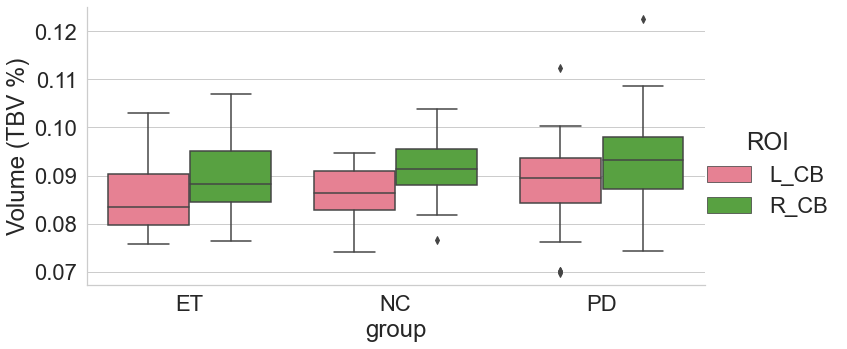

In [8]:
sns.set(font_scale=2)
palette = sns.color_palette('husl',3)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='volume', x='group', hue='ROI', kind='box',aspect=2, height=5, palette = palette,
                    data=plot_df)
    if normalize:
        plt.ylabel('Volume (TBV %)')

### ROI volumes

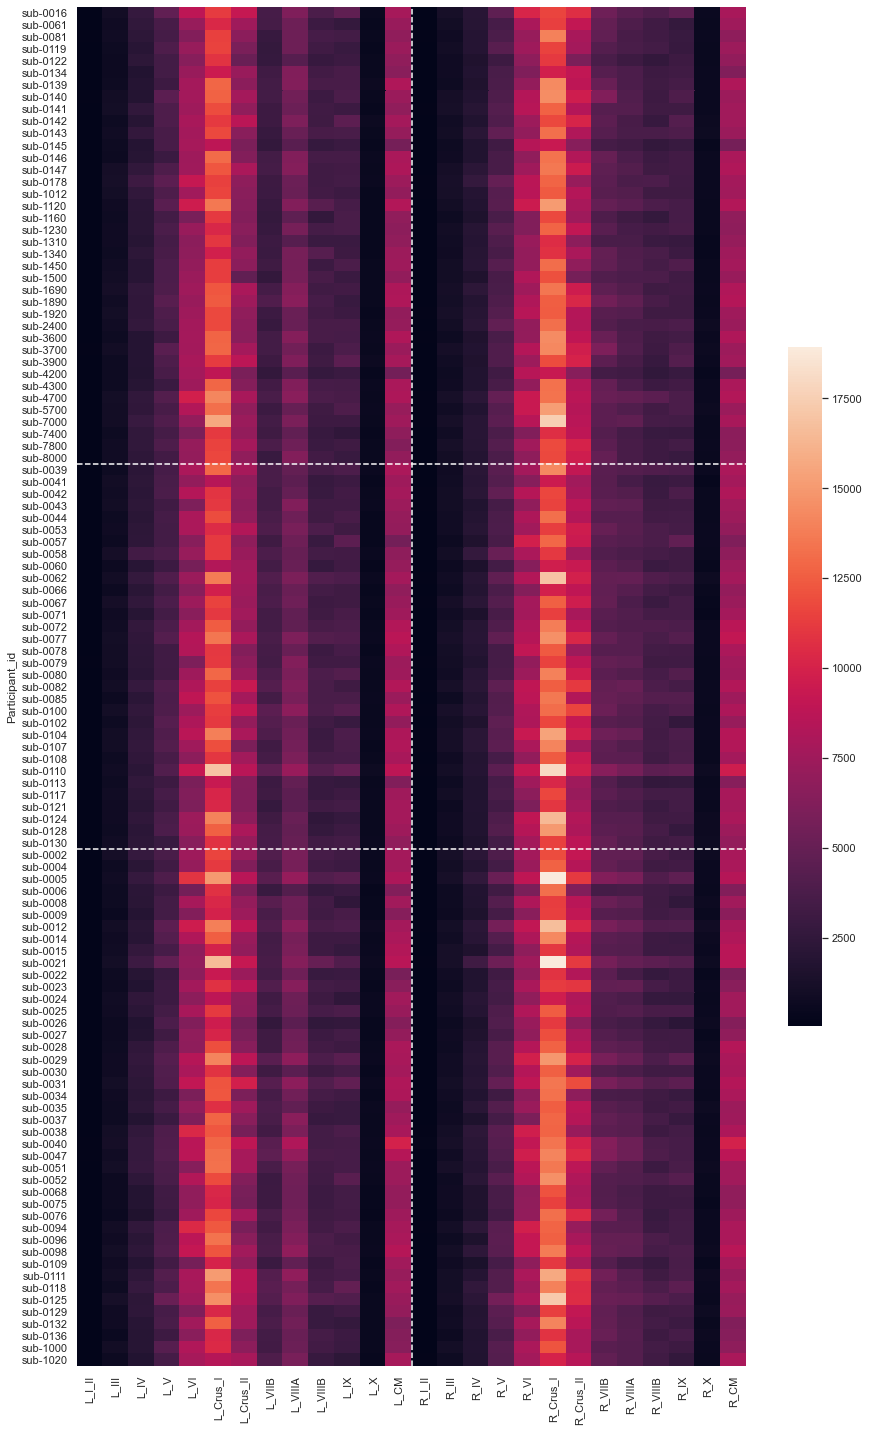

In [9]:
plot_df = vol_df_concat.copy()
plot_df = plot_df.set_index('Participant_id')
plot_df = plot_df[cols_L + cols_R ]
sns.set(font_scale=1)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 25))
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5})

    for h_line in h_lines:
        plt.axhline(h_line, ls='--',c='white')
    plt.axvline(v_lines, ls='--',c='white')

### Group comparisons

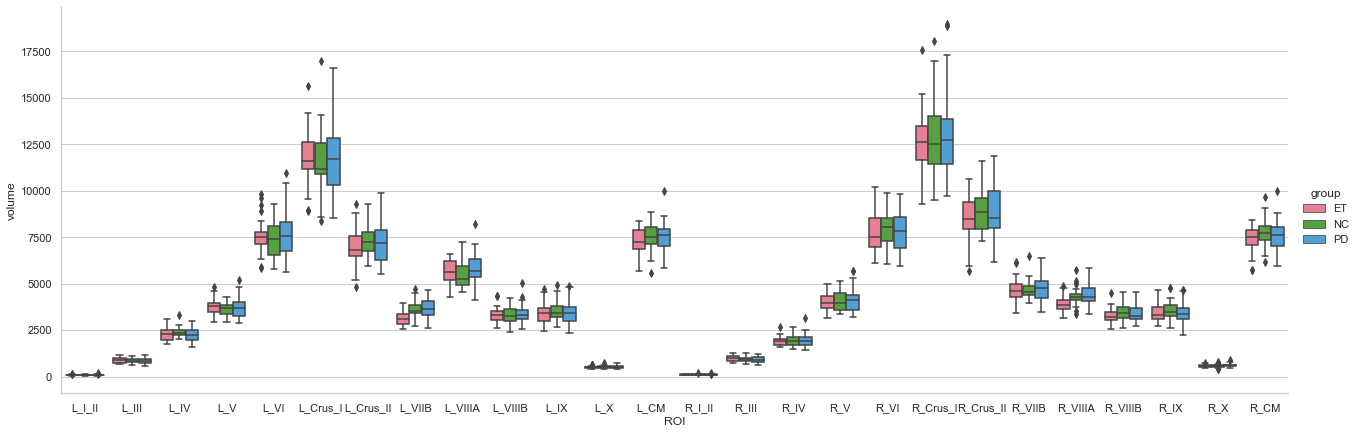

In [10]:
plot_df = vol_df_concat.copy()
plot_df = plot_df[['Participant_id','group'] + cols_L + cols_R]

palette = sns.color_palette('husl',3)
with sns.axes_style("whitegrid"):
    plot_df = pd.melt(plot_df, id_vars = ['Participant_id','group'], value_vars = cols_L + cols_R, 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_df)

 

## OLS
- Find signficant difference between NC, ET, PD groups based on ROI volumes
- Correct for multiple comparison

In [11]:
stat_df = pd.merge(vol_df_concat,analysis_df,on=['Participant_id','group'],how='inner')
print('Total number of participants in the analysis after volume_df ({}) + demo_df ({}) merge : {}'.format(len(vol_df_concat),len(analysis_df),len(stat_df)))
group_sizes = stat_df.value_counts(['group'])
print('Number of Participant_ids:\n{}'.format(group_sizes))

stat_cols = cols_L+cols_R+['L_CB', 'R_CB', 'brain_volume','Age']

stat_df[stat_cols] = stat_df[stat_cols].astype(int)

# regression (# check model with Age only)
independent_var = 'C(group, Treatment(reference=\'NC\'))' #'Age'
compare_levels =  ['C(group, Treatment(reference=\'NC\'))[T.ET]','C(group, Treatment(reference=\'NC\'))[T.PD]'] #'Age'
covars = 'brain_volume + Age + C(Sex)' #'brain_volume + C(Sex)' 

# OLS result df
res_df_concat = pd.DataFrame()
for dependent_var in cols_L + ['L_CB'] + cols_R + ['R_CB']:
    res = smf.ols(formula='{} ~ {} + {}'.format(dependent_var, covars, independent_var), data=stat_df).fit()
    res_df = format_ols_results(res)
    res_df['dependent_var'] = dependent_var
    res_df_concat = res_df_concat.append(res_df)

res_df_concat.head()

Total number of participants in the analysis after volume_df (113) + demo_df (113) merge : 113
Number of Participant_ids:
group
PD       43
ET       38
NC       32
dtype: int64


,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,dependent_var
0,Intercept,-20.72110,27.147000,-0.763,0.447,-74.537000,33.095,0.193927,0.15626,L_I_II
1,C(Sex)[T.M],3.38940,5.014000,0.676,0.501,-6.551000,13.330,0.193927,0.15626,L_I_II
2,"C(group, Treatment(reference='NC'))[T.ET]",5.31790,6.406000,0.830,0.408,-7.381000,18.016,0.193927,0.15626,L_I_II
3,"C(group, Treatment(reference='NC'))[T.PD]",-1.15640,5.123000,-0.226,0.822,-11.313000,9.000,0.193927,0.15626,L_I_II
4,brain_volume,0.00007,0.000019,3.641,0.000,0.000032,0.000,0.193927,0.15626,L_I_II


## Plots
### significance and model fit (R2)

Using corrected p-val threshold of 0.0038
signficant ROIs: ['L_VIIIA']


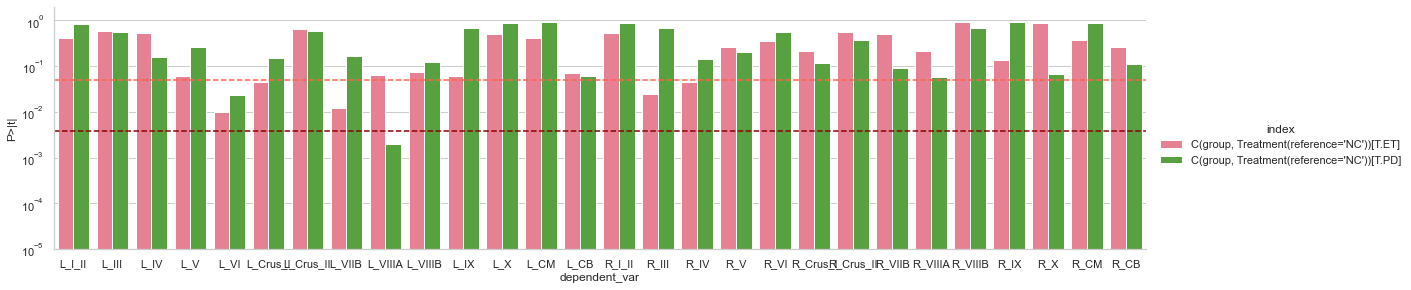

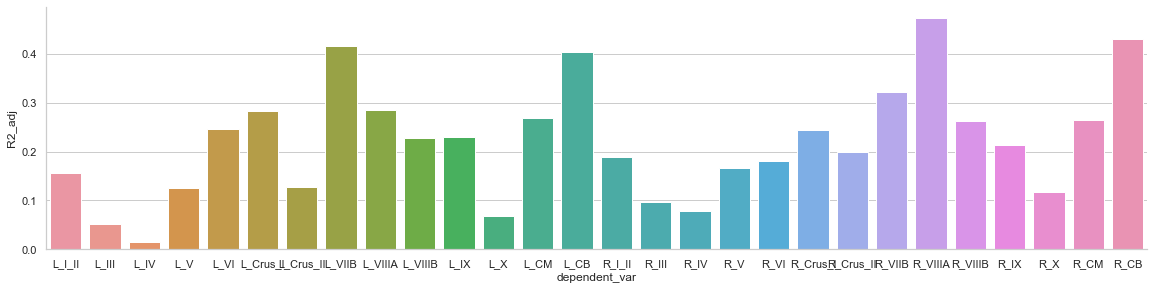

In [12]:
plot_df = res_df_concat[res_df_concat['index'].isin(compare_levels)].copy()
n_compare = len(cols_L) #len(cols_L+cols_R)
signific_thesh = 0.05/(n_compare)
print('Using corrected p-val threshold of {:5.4f}'.format(signific_thesh))

signific_ROIs = plot_df[plot_df['P>|t|'] < signific_thesh]['dependent_var'].values
print('signficant ROIs: {}'.format(signific_ROIs))

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='P>|t|', x='dependent_var', kind='bar', hue='index', aspect=4, height=4, palette=palette,
                    data=plot_df)
    g.set(yscale='log',ylim=(1e-5,2))
    plt.axhline(0.05, ls='--',c='tomato')
    plt.axhline(signific_thesh, ls='--',c='darkred')

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='R2_adj', x='dependent_var', kind='bar', aspect=4, height=4, 
                    data=plot_df)

In [13]:
signific_df = res_df_concat[res_df_concat['dependent_var'].isin(signific_ROIs)]
signific_df

,index,coef,std err,t,P>|t|,[0.025,0.975],R2,R2_adj,dependent_var
0,Intercept,2910.0577,788.876,3.689,0.000,1346.203,4473.912,0.317871,0.285996,L_VIIIA
1,C(Sex)[T.M],280.1730,145.717,1.923,0.057,-8.693,569.039,0.317871,0.285996,L_VIIIA
2,"C(group, Treatment(reference='NC'))[T.ET]",346.9514,186.145,1.864,0.065,-22.059,715.962,0.317871,0.285996,L_VIIIA
3,"C(group, Treatment(reference='NC'))[T.PD]",461.7284,148.881,3.101,0.002,166.590,756.867,0.317871,0.285996,L_VIIIA
4,brain_volume,0.0023,0.001,4.098,0.000,0.001,0.003,0.317871,0.285996,L_VIIIA
5,Age,-12.0842,6.558,-1.843,0.068,-25.085,0.917,0.317871,0.285996,L_VIIIA
